# Import Necessary Libraries

In [1]:
!pip install pycocotools --no-binary pycocotools

  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.7-cp310-cp310-linux_x86_64.whl size=101912 sha256=eccf5f5c1d55539511eb2aaa7a57383f845711f0d99baadb7996c7054d4221d5
  Stored in directory: /root/.cache/pip/wheels/40/b5/c8/9afe18bb3839192bffca22717e7b85080b1f847c57216d868f
Successfully built pycocotools


In [2]:
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# OpenCV
import cv2

# ScikitLearn for Data Splitting
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Pytorch
import torch
import torchvision
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN, retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
from functools import partial
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights



from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from torchmetrics.detection import MeanAveragePrecision

# Others
from math import ceil
from pprint import pprint

In [3]:
SEED = 21520006

def fix_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

fix_seed(SEED)

In [4]:
EPOCHS = 15
BATCH_SIZE = 16

# Load Data

In [5]:
DATA_PATH = '../input/lisa-traffic-light-dataset'
os.listdir(DATA_PATH)

['nightTrain',
 'nightSequence1',
 'daySequence1',
 'Annotations',
 'sample-nightClip1',
 'sample-dayClip6',
 'daySequence2',
 'nightSequence2',
 'dayTrain']

In [6]:
DAY_TRAIN_PATH = '../input/lisa-traffic-light-dataset/Annotations/Annotations/dayTrain/'
NIGHT_TRAIN_PATH = '../input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/'

In [7]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)
train_day_df['isNight'] = 0
    
train_night = []
for clipName in tqdm(sorted(os.listdir(NIGHT_TRAIN_PATH))):
    if 'nightClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(NIGHT_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_night.append(df)

train_night_df = pd.concat(train_night,axis=0)
train_night_df['isNight'] = 1

df = pd.concat([train_day_df,train_night_df],axis=0)


100%|██████████| 5/5 [00:00<00:00, 63.74it/s]


In [8]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0


# Preprocess Data

In [9]:
# Drops columns that won't be used
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

In [10]:
# Change column "Filename" to match locations in the dataset folder.
def changeFilename(x):
    filename = x.Filename
    isNight = x.isNight
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    if isNight:
        return os.path.join(DATA_PATH,f'nightTrain/nightTrain/{clipName}/frames/{splitted[-1]}')
    else:
        return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [11]:
df['Annotation tag'].unique()


array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [12]:
label_to_idx = {'go':1, 'warning':2, 'stop': 3}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([1, 3, 2])

In [13]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number,isNight
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,333,710,358,0,0
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,846,391,858,411,0,0
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,337,710,357,1,0
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,847,390,859,410,1,0
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,331,710,356,2,0


In [14]:
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame','isNight']

In [15]:
df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,333,710,358,0,0
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,846,391,858,411,0,0
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,337,710,357,1,0
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,847,390,859,410,1,0
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,331,710,356,2,0


In [16]:
class_1 = df[df['label'] == 1]
class_2 = df[df['label'] == 2]
class_3 = df[df['label'] == 3]

# Calculate the number of instances in each class
count_class_1 = len(class_1)
count_class_2 = len(class_2)
count_class_3 = len(class_3)


In [17]:
count_class_1, count_class_2, count_class_3

(24182, 1555, 26089)

In [18]:
target_count = count_class_1//2

In [19]:
from sklearn.utils import resample

class_2_oversampled = resample(class_2, replace=True, n_samples=target_count, random_state=SEED)

class_1_undersampled = resample(class_1, replace=False, n_samples=target_count, random_state=SEED)
class_3_undersampled = resample(class_3, replace=False, n_samples=target_count, random_state=SEED)

balanced_df = pd.concat([class_1_undersampled, class_2_oversampled, class_3_undersampled])

df = balanced_df.sample(frac=1, random_state=SEED).reset_index(drop=True)


In [20]:
print("Number of Unique Images: ",df.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  14615 / 36273


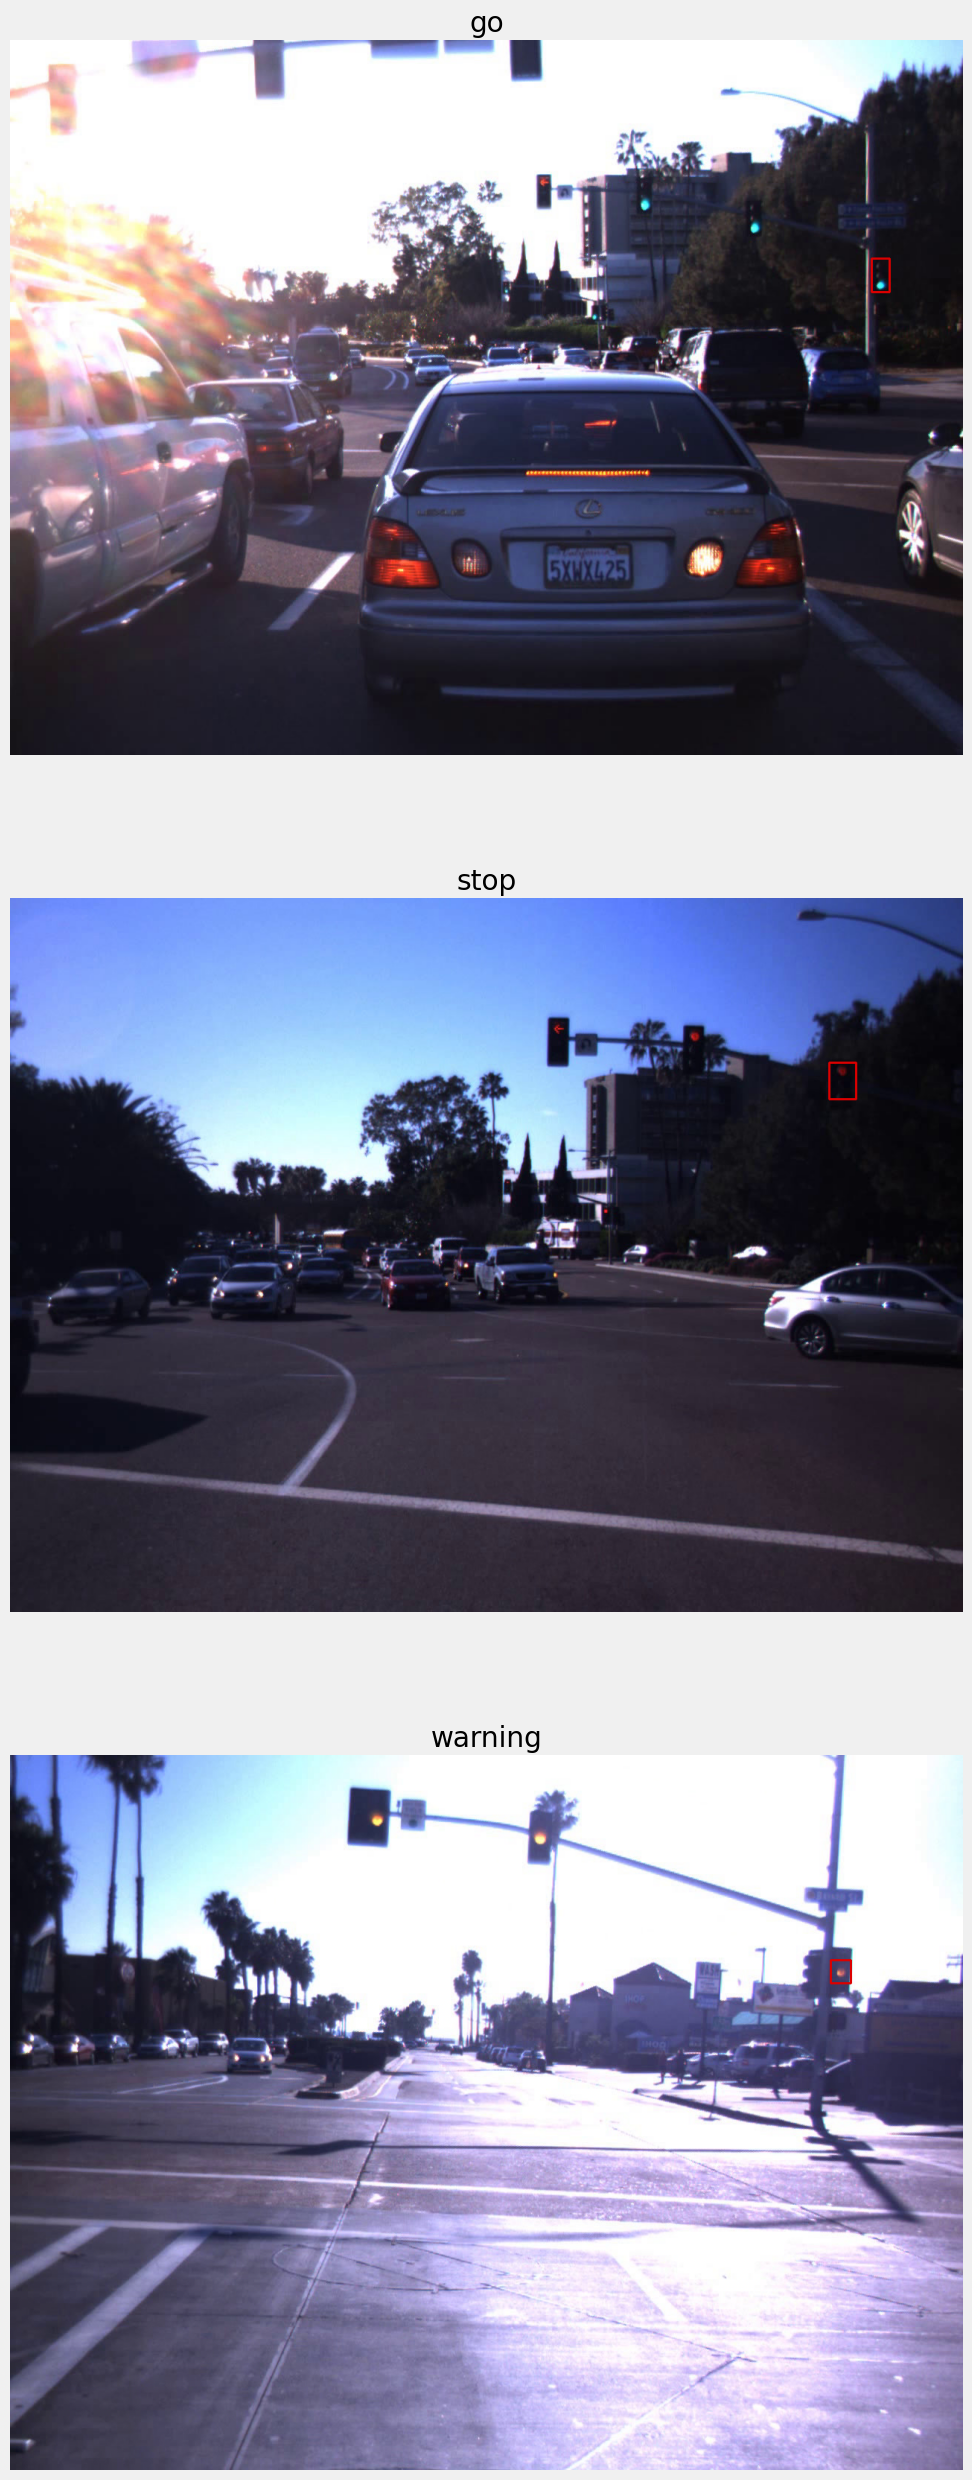

In [21]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

In [22]:
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[5])
df['clipNames'].unique()

array(['dayClip13', 'dayClip1', 'dayClip7', 'dayClip11', 'dayClip5',
       'nightClip4', 'nightClip3', 'dayClip9', 'nightClip2', 'dayClip2',
       'nightClip5', 'dayClip3', 'dayClip4', 'dayClip8', 'dayClip6',
       'nightClip1', 'dayClip12', 'dayClip10'], dtype=object)

In [23]:
def split(df,p=0.2):
    clipNames = sorted(df['clipNames'].unique())

    nightClips = [name for name in clipNames if 'night' in name]
    dayClips = [name for name in clipNames if 'day' in name]

    testNightClipNames = list(np.random.choice(nightClips,min(1,int(len(nightClips)*p))))
    testDayClipNames = list(np.random.choice(dayClips,min(1,int(len(dayClips)*p))))
    testClipNames = testNightClipNames + testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainNightClipNames = list(set(nightClips) - set(testNightClipNames))
    trainClipNames = trainNightClipNames + trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

In [24]:
train_df, test_df = split(df)

In [25]:
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,../input/lisa-traffic-light-dataset/dayTrain/d...,2,876,307,900,343,180,0,dayClip13
1,../input/lisa-traffic-light-dataset/dayTrain/d...,3,796,233,820,278,215,0,dayClip1
2,../input/lisa-traffic-light-dataset/dayTrain/d...,2,1030,401,1045,423,140,0,dayClip7
3,../input/lisa-traffic-light-dataset/dayTrain/d...,3,74,286,104,340,28,0,dayClip11
4,../input/lisa-traffic-light-dataset/dayTrain/d...,2,912,298,939,352,89,0,dayClip5


In [26]:
test_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
8,../input/lisa-traffic-light-dataset/nightTrain...,1,770,336,784,357,890,1,nightClip3
37,../input/lisa-traffic-light-dataset/nightTrain...,1,801,63,903,210,170,1,nightClip3
54,../input/lisa-traffic-light-dataset/nightTrain...,1,847,352,854,364,827,1,nightClip3
86,../input/lisa-traffic-light-dataset/dayTrain/d...,3,130,265,154,292,69,0,dayClip6
132,../input/lisa-traffic-light-dataset/nightTrain...,3,868,199,901,266,14,1,nightClip3


In [27]:
day_test_df = test_df[test_df['isNight'] == 0]
night_test_df = test_df[test_df['isNight'] == 1]


In [28]:
night_test_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
8,../input/lisa-traffic-light-dataset/nightTrain...,1,770,336,784,357,890,1,nightClip3
37,../input/lisa-traffic-light-dataset/nightTrain...,1,801,63,903,210,170,1,nightClip3
54,../input/lisa-traffic-light-dataset/nightTrain...,1,847,352,854,364,827,1,nightClip3
132,../input/lisa-traffic-light-dataset/nightTrain...,3,868,199,901,266,14,1,nightClip3
142,../input/lisa-traffic-light-dataset/nightTrain...,1,724,296,738,317,876,1,nightClip3


In [29]:
print("Train shape: ",train_df.shape)
print("Test shape: ",test_df.shape)

Train shape:  (34672, 9)
Test shape:  (1601, 9)


In [30]:
train_df, val_df = split(train_df)
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,../input/lisa-traffic-light-dataset/dayTrain/d...,2,876,307,900,343,180,0,dayClip13
1,../input/lisa-traffic-light-dataset/dayTrain/d...,3,796,233,820,278,215,0,dayClip1
2,../input/lisa-traffic-light-dataset/dayTrain/d...,2,1030,401,1045,423,140,0,dayClip7
3,../input/lisa-traffic-light-dataset/dayTrain/d...,3,74,286,104,340,28,0,dayClip11
6,../input/lisa-traffic-light-dataset/nightTrain...,3,716,314,737,357,702,1,nightClip4


In [31]:
val_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
4,../input/lisa-traffic-light-dataset/dayTrain/d...,2,912,298,939,352,89,0,dayClip5
5,../input/lisa-traffic-light-dataset/dayTrain/d...,2,688,311,709,342,73,0,dayClip5
9,../input/lisa-traffic-light-dataset/dayTrain/d...,1,918,124,969,214,2328,0,dayClip5
15,../input/lisa-traffic-light-dataset/dayTrain/d...,3,717,127,777,212,2300,0,dayClip5
22,../input/lisa-traffic-light-dataset/dayTrain/d...,2,278,407,302,456,42,0,dayClip5


In [32]:
print("Train shape: ",train_df.shape)
print("Validation shape: ",val_df.shape)

Train shape:  (27226, 9)
Validation shape:  (7446, 9)


In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [34]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()

        # Image_ids will be the "Filename" here
        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        # Reading Image
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # Bounding Boxes
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        
        # Area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Labels of the object detected
        labels = torch.as_tensor(records.label.values, dtype=torch.int64)
        
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            # target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])
            
        return image, target, image_id

In [35]:
def collate_fn(batch):
    # Normalize the image data using the specified mean and standard deviation values
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    # Combine the corresponding elements of each tuple in the input batch
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    image_ids = [item[2] for item in batch]

    # Normalize each image tensor
    for i in range(len(images)):
        images[i] = normalize(images[i])

    # Combine normalized images and targets
    return (images, targets, image_ids)


In [36]:
class LossAverager:
    # Computes and stores the average and current value
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [37]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [38]:
def getTrainTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        A.Flip(0.5),
        A.RandomBrightnessContrast(p=0.3),
        ToTensorV2(p=1.0), 
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# For Validation Data
def getValTransform():
    return A.Compose([
#         A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# For Test Data
def getTestTransform():
    return A.Compose([
#         A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [39]:
trainDataset = TrafficLightsDataset(train_df,getTrainTransform())
valDataset = TrafficLightsDataset(val_df,getValTransform())
testDataset = TrafficLightsDataset(test_df,getTestTransform())
dayTestDataset = TrafficLightsDataset(day_test_df,getTestTransform())
nightTestDataset = TrafficLightsDataset(night_test_df,getTestTransform())

In [40]:
def augment_minor_class(dataset, minority_class_indices, num_augmentations=2):
    augmentation_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ])

    augmented_samples = []

    for index in minority_class_indices:
        original_sample = dataset[index]
        for _ in range(num_augmentations):
            augmented_sample = {
                'image': augmentation_transform(original_sample['image']),
                'target': original_sample['target']
            }
            augmented_samples.append(augmented_sample)

    augmented_dataset = torch.utils.data.ConcatDataset([dataset, augmented_samples])

    return augmented_dataset


In [41]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

dayTestDataLoader = DataLoader(
    dayTestDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

nightTestDataLoader = DataLoader(
    nightTestDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [42]:
images, targets, image_ids = next(iter(trainDataLoader))

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
image = images[0].permute(1,2,0).cpu().numpy()

In [43]:
targets[0]

{'boxes': tensor([[284.0000, 386.6667, 304.4000, 425.0667]]),
 'labels': tensor([3]),
 'image_id': tensor([10733]),
 'area': tensor([3672.]),
 'iscrowd': tensor([0])}

In [44]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

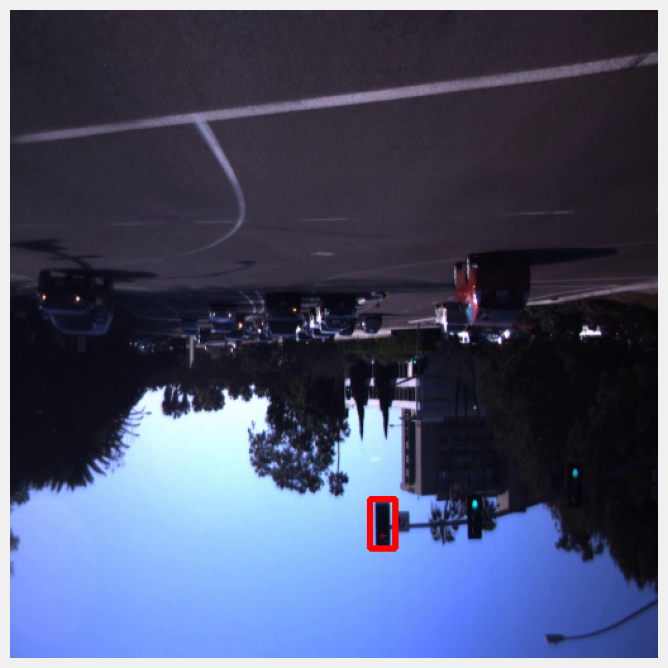

In [45]:
displayImage(image,boxes)

In [46]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False

# N_CLASS = 4  # 3 classes (Stop, Warning, Go) + Background

# # Number of Input Features for the Classifier Head
# INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

# # New Head for Classification
# model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

# model.to(device)

# Define Training & Evaluating Functions

In [47]:
def train(model, save_path, trainDataLoader, optimizer, lr_scheduler = None):
    lossHist = LossAverager()
    valLossHist = LossAverager()

    for epoch in range(EPOCHS):

        start_time = time()
        model.train()
        lossHist.reset()

        for images, targets, image_ids in tqdm(trainDataLoader):

            images = torch.stack(images).to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            bs = images.shape[0]

            loss_dict = model(images, targets)

            totalLoss = sum(loss for loss in loss_dict.values())
            lossValue = totalLoss.item()

            lossHist.update(lossValue,bs)

            optimizer.zero_grad()
            totalLoss.backward()
            optimizer.step()

        # LR Update
        if lr_scheduler is not None:
            lr_scheduler.step(totalLoss)


        print(f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}]")
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train loss: {lossHist.avg}")

        torch.save(model.state_dict(), save_path)

In [48]:
def filterBoxes(output,nms_th=0.5,score_threshold=0.5):
    
    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']
    
    # Non Max Supression
    mask = nms(boxes,scores,nms_th)
    
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return boxes, scores, labels

In [49]:
def displayPredictions(image_id,output,nms_th=0.3,score_threshold=0.5):
    
    boxes,scores,labels = filterBoxes(output,nms_th,score_threshold)
    
    # Preprocessing
    image = cv2.imread(image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image,(512,512))
    image /= 255.0
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}
    
    for box,label in zip(boxes,labels):
        image = cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      colors[label], 2)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()


In [50]:
def evaluate(model, dataLoader):
    model.eval()

    mAP = MeanAveragePrecision()  # num_classes should be defined
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets, image_ids in tqdm(dataLoader):
            images = torch.stack(images).to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            predictions = model(images)

            for idx in range(len(predictions)):
                pred_boxes, pred_scores, pred_labels = filterBoxes(predictions[idx])

                # Convert to tensors
                pred_boxes = torch.tensor(pred_boxes).to(device)
                pred_scores = torch.tensor(pred_scores).to(device)
                pred_labels = torch.tensor(pred_labels).to(device)

                # Collect predictions and targets for the entire dataset
                pred_dict = {
                    'boxes': pred_boxes,
                    'scores': pred_scores,
                    'labels': pred_labels
                }
                all_predictions.append(pred_dict)

                targ_dict = {
                    'boxes': targets[idx]['boxes'].to(device),
                    'labels': targets[idx]['labels'].to(device),
                    'scores': torch.ones(len(targets[idx]['labels']), device=device)
                }
                all_targets.append(targ_dict)

    # Compute mAP for all predictions and targets
    mAP.update(all_predictions, all_targets)

    # Calculate the final mAP
    final_map = mAP.compute()
    print("Mean Average Precision (mAP):", final_map)

# Faster R-CNN

## Training

In [51]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

N_CLASS = 4  # 3 classes (Stop, Warning, Go) + Background

# Number of Input Features for the Classifier Head
INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

# New Head for Classification
model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 261MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [52]:
params = [p for p in model.parameters() if p.requires_grad]
# Optimizers
optimizer = torch.optim.Adam(params)

# LR Scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [53]:
FASTER_RCNN_WEIGHTS_PATH =  "fasterrcnn_resnet50_fpn.pth"

In [54]:
train(model, FASTER_RCNN_WEIGHTS_PATH, trainDataLoader, optimizer, lr_scheduler)

100%|██████████| 710/710 [09:13<00:00,  1.28it/s]


[09:14]
Epoch 1/15
Train loss: 0.3881628711458071


100%|██████████| 710/710 [09:07<00:00,  1.30it/s]


[09:07]
Epoch 2/15
Train loss: 0.3557793875164157


100%|██████████| 710/710 [09:11<00:00,  1.29it/s]


[09:11]
Epoch 3/15
Train loss: 0.3514449276479147


100%|██████████| 710/710 [09:10<00:00,  1.29it/s]


[09:10]
Epoch 4/15
Train loss: 0.3475245376645069


100%|██████████| 710/710 [09:10<00:00,  1.29it/s]


[09:10]
Epoch 5/15
Train loss: 0.34547168433477143


100%|██████████| 710/710 [09:11<00:00,  1.29it/s]


[09:11]
Epoch 6/15
Train loss: 0.3452741817180901


100%|██████████| 710/710 [09:12<00:00,  1.28it/s]


[09:12]
Epoch 7/15
Train loss: 0.34008648888637033


100%|██████████| 710/710 [09:11<00:00,  1.29it/s]


[09:11]
Epoch 8/15
Train loss: 0.336384883839184


100%|██████████| 710/710 [09:11<00:00,  1.29it/s]


[09:11]
Epoch 9/15
Train loss: 0.3378752245107166


100%|██████████| 710/710 [09:12<00:00,  1.28it/s]


[09:12]
Epoch 10/15
Train loss: 0.3389784287914744


100%|██████████| 710/710 [09:11<00:00,  1.29it/s]


[09:11]
Epoch 11/15
Train loss: 0.3376894002549868


100%|██████████| 710/710 [09:15<00:00,  1.28it/s]


[09:15]
Epoch 12/15
Train loss: 0.33747157308472936


100%|██████████| 710/710 [09:12<00:00,  1.28it/s]


[09:12]
Epoch 13/15
Train loss: 0.33576890317264224


100%|██████████| 710/710 [09:13<00:00,  1.28it/s]


[09:13]
Epoch 14/15
Train loss: 0.3319473531271817


100%|██████████| 710/710 [09:15<00:00,  1.28it/s]


[09:15]
Epoch 15/15
Train loss: 0.3323686034233166


## Inference

In [55]:
# !pip install gdown

In [56]:
# !gdown --id 1qRfzmvxVpTMQrXaHnrE1Y6mht70bCLZH

In [57]:
# !gdown --id 1Runo_3V2nHfg7ON37rAC673iN_rV13M5

In [58]:
# !gdown --id 1RGlk4ojs6w4aiqyiI6LDazigo-XI96_B

In [59]:
model.load_state_dict(torch.load(FASTER_RCNN_WEIGHTS_PATH))

<All keys matched successfully>

In [60]:
model.eval()
images, targets, image_ids = next(iter(valDataLoader))
print(images[0].shape)
images = torch.stack(images).to(device)

outputs = model(images)
print(len(image_ids))

torch.Size([3, 960, 1280])
16


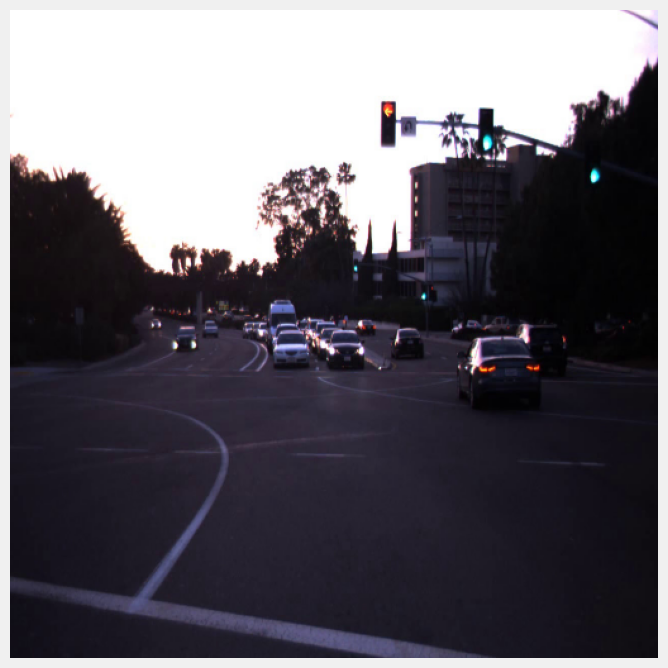

In [61]:
displayPredictions(image_ids[2],outputs[2],0.4,0.5)

## Evaluate

### Evaluate on day sequences

In [62]:
evaluate(model, dayTestDataLoader)

100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


Mean Average Precision (mAP): {'map': tensor(0.0066), 'map_50': tensor(0.0285), 'map_75': tensor(0.0003), 'map_small': tensor(0.0076), 'map_medium': tensor(0.0126), 'map_large': tensor(-1.), 'mar_1': tensor(0.0248), 'mar_10': tensor(0.0306), 'mar_100': tensor(0.0306), 'mar_small': tensor(0.0251), 'mar_medium': tensor(0.0516), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3], dtype=torch.int32)}


### Evaluate on night sequences

In [63]:
evaluate(model, nightTestDataLoader)

100%|██████████| 35/35 [00:41<00:00,  1.20s/it]


Mean Average Precision (mAP): {'map': tensor(0.0086), 'map_50': tensor(0.0298), 'map_75': tensor(0.0015), 'map_small': tensor(0.0050), 'map_medium': tensor(0.0228), 'map_large': tensor(0.), 'mar_1': tensor(0.0304), 'mar_10': tensor(0.0367), 'mar_100': tensor(0.0367), 'mar_small': tensor(0.0160), 'mar_medium': tensor(0.0768), 'mar_large': tensor(0.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3], dtype=torch.int32)}


# SSD

## Training

In [64]:

model = ssd300_vgg16(weights = "DEFAULT", 
                     nms_thresh = 0.3,
#                      topk_candidates = 400,
#                      detections_per_img = 200,
#                      score_thresh = 0.1
                    )

model.head.classification_head = ssd300_vgg16(weights=None, num_classes=N_CLASS).head.classification_head
model.to(device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 221MB/s]
Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:13<00:00, 40.9MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [65]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4, betas=(0.7, 0.89), weight_decay=5e-6)

# and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [66]:
SSD300_WEIGHTS_PATH = "ssd300_vgg16.pth"

In [67]:
train(model, SSD300_WEIGHTS_PATH, trainDataLoader, optimizer, lr_scheduler)

100%|██████████| 710/710 [06:47<00:00,  1.74it/s]


[06:47]
Epoch 1/15
Train loss: 3.7460201125267654


100%|██████████| 710/710 [06:47<00:00,  1.74it/s]


[06:47]
Epoch 2/15
Train loss: 3.349182628770088


100%|██████████| 710/710 [06:46<00:00,  1.75it/s]


[06:46]
Epoch 3/15
Train loss: 3.3158395282811246


100%|██████████| 710/710 [06:45<00:00,  1.75it/s]


[06:45]
Epoch 4/15
Train loss: 2.4268461134301806


100%|██████████| 710/710 [06:45<00:00,  1.75it/s]


[06:45]
Epoch 5/15
Train loss: 4.052907256538867


100%|██████████| 710/710 [06:47<00:00,  1.74it/s]


[06:47]
Epoch 6/15
Train loss: 2.301474597700305


100%|██████████| 710/710 [06:46<00:00,  1.75it/s]


[06:46]
Epoch 7/15
Train loss: 2.1991891269747708


100%|██████████| 710/710 [06:46<00:00,  1.75it/s]


[06:46]
Epoch 8/15
Train loss: 16.379859825822724


100%|██████████| 710/710 [06:46<00:00,  1.75it/s]


[06:46]
Epoch 9/15
Train loss: 2.8781077105435093


100%|██████████| 710/710 [06:47<00:00,  1.74it/s]


[06:47]
Epoch 10/15
Train loss: 2.744944755989857


100%|██████████| 710/710 [06:46<00:00,  1.74it/s]


[06:46]
Epoch 11/15
Train loss: 2.159534208615733


100%|██████████| 710/710 [06:47<00:00,  1.74it/s]


[06:47]
Epoch 12/15
Train loss: 9.459128685807695


100%|██████████| 710/710 [06:47<00:00,  1.74it/s]


[06:47]
Epoch 13/15
Train loss: 2.6015375652992265


100%|██████████| 710/710 [06:46<00:00,  1.74it/s]


[06:46]
Epoch 14/15
Train loss: 4.68306443722348


100%|██████████| 710/710 [06:47<00:00,  1.74it/s]


[06:47]
Epoch 15/15
Train loss: 2.3067829999278286


In [68]:
model.load_state_dict(torch.load(SSD300_WEIGHTS_PATH))

<All keys matched successfully>

## Evaluating

### Evaluate on day sequences

In [69]:
evaluate(model, dayTestDataLoader)

100%|██████████| 22/22 [00:16<00:00,  1.31it/s]


Mean Average Precision (mAP): {'map': tensor(0.0286), 'map_50': tensor(0.0559), 'map_75': tensor(0.0101), 'map_small': tensor(0.0269), 'map_medium': tensor(0.0419), 'map_large': tensor(-1.), 'mar_1': tensor(0.0468), 'mar_10': tensor(0.0468), 'mar_100': tensor(0.0468), 'mar_small': tensor(0.0427), 'mar_medium': tensor(0.0651), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 3], dtype=torch.int32)}


### Evaluate on night sequences

In [70]:
evaluate(model, nightTestDataLoader)

100%|██████████| 35/35 [00:26<00:00,  1.33it/s]


Mean Average Precision (mAP): {'map': tensor(0.0225), 'map_50': tensor(0.0462), 'map_75': tensor(0.0226), 'map_small': tensor(0.0036), 'map_medium': tensor(0.0479), 'map_large': tensor(0.), 'mar_1': tensor(0.0361), 'mar_10': tensor(0.0433), 'mar_100': tensor(0.0433), 'mar_small': tensor(0.0110), 'mar_medium': tensor(0.0893), 'mar_large': tensor(0.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3], dtype=torch.int32)}


# RetinaNet

## Training

In [71]:

model = retinanet_resnet50_fpn_v2(weights='DEFAULT',
                                  trainable_backbone_layers=1)

model.head = retinanet_resnet50_fpn_v2(weights=None, num_classes=N_CLASS).head

model.to(device)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:02<00:00, 71.6MB/s]


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [72]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4, betas=(0.8, 0.89), weight_decay=5e-6)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [73]:
RETINANET_WEIGHTS_PATH = "retinanet_resnet50_fpn_v2.pth"

In [74]:
train(model, RETINANET_WEIGHTS_PATH, trainDataLoader, optimizer, lr_scheduler)

100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:34]
Epoch 1/15
Train loss: 0.6684406653734677


100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:34]
Epoch 2/15
Train loss: 0.4850060475053273


100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:34]
Epoch 3/15
Train loss: 0.4370178785549321


100%|██████████| 710/710 [11:35<00:00,  1.02it/s]


[11:35]
Epoch 4/15
Train loss: 0.4090344216523559


100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:34]
Epoch 5/15
Train loss: 0.38979071591956793


100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:34]
Epoch 6/15
Train loss: 0.37507674545522385


100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:34]
Epoch 7/15
Train loss: 0.3653077851898199


100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:35]
Epoch 8/15
Train loss: 0.3541309208591765


100%|██████████| 710/710 [11:35<00:00,  1.02it/s]


[11:35]
Epoch 9/15
Train loss: 0.3447229631000898


100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:34]
Epoch 10/15
Train loss: 0.3368437742426398


100%|██████████| 710/710 [11:35<00:00,  1.02it/s]


[11:35]
Epoch 11/15
Train loss: 0.33146087157713683


100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:34]
Epoch 12/15
Train loss: 0.3239841100549379


100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:34]
Epoch 13/15
Train loss: 0.3183965865610601


100%|██████████| 710/710 [11:34<00:00,  1.02it/s]


[11:34]
Epoch 14/15
Train loss: 0.31403816307267546


100%|██████████| 710/710 [11:35<00:00,  1.02it/s]


[11:35]
Epoch 15/15
Train loss: 0.3077360972326156


In [75]:
model.load_state_dict(torch.load(RETINANET_WEIGHTS_PATH))

<All keys matched successfully>

## Evaluating

### Evaluate on day sequences

In [76]:
evaluate(model, dayTestDataLoader)

100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Mean Average Precision (mAP): {'map': tensor(0.0081), 'map_50': tensor(0.0285), 'map_75': tensor(0.0006), 'map_small': tensor(0.0103), 'map_medium': tensor(0.0020), 'map_large': tensor(-1.), 'mar_1': tensor(0.0135), 'mar_10': tensor(0.0135), 'mar_100': tensor(0.0135), 'mar_small': tensor(0.0171), 'mar_medium': tensor(0.0047), 'mar_large': tensor(-1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 3], dtype=torch.int32)}


### Evaluate on night sequences

In [77]:
evaluate(model, nightTestDataLoader)

100%|██████████| 35/35 [00:35<00:00,  1.00s/it]


Mean Average Precision (mAP): {'map': tensor(0.0151), 'map_50': tensor(0.0475), 'map_75': tensor(0.0051), 'map_small': tensor(0.0343), 'map_medium': tensor(0.0184), 'map_large': tensor(0.0327), 'mar_1': tensor(0.0303), 'mar_10': tensor(0.0325), 'mar_100': tensor(0.0325), 'mar_small': tensor(0.0783), 'mar_medium': tensor(0.0302), 'mar_large': tensor(0.0318), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3], dtype=torch.int32)}


## Demo

In [78]:
# from torch.utils.data import DataLoader, Dataset
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.patches import Rectangle
# import torch

# # Assuming you have defined filterBoxes function and 'model' and 'device' are initialized

# def predict_image(image_path, model):
#     img = Image.open(image_path)
#     original_size = img.size  # Store the original size
    
#     transform_norm = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((512, 512))
#     ])
#     img_normalized = transform_norm(img).float()
#     img_normalized = img_normalized.unsqueeze_(0)
#     img_normalized = img_normalized.to(device)
    
#     with torch.no_grad():
#         model.eval()
#         predictions = model(img_normalized)
        
#         # Display the resized image
#         plt.figure(figsize=(8, 8))
#         plt.imshow(img)
        
#         pred_boxes, pred_scores, pred_labels = filterBoxes(predictions[0])
#         pred_boxes = torch.tensor(pred_boxes)
#         pred_scores = torch.tensor(pred_scores)
#         pred_labels = torch.tensor(pred_labels)
        
#         for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
#             # Resize the bounding boxes to the original size
#             box_resized = [
#                 box[0] * original_size[0] / 512,
#                 box[1] * original_size[1] / 512,
#                 box[2] * original_size[0] / 512,
#                 box[3] * original_size[1] / 512
#             ]
            
#             rect = Rectangle(
#                 xy=(box_resized[0], box_resized[1]),
#                 width=box_resized[2] - box_resized[0],
#                 height=box_resized[3] - box_resized[1],
#                 edgecolor='r',
#                 fill=False
#             )
#             plt.gca().add_patch(rect)
#             plt.text(box_resized[0], box_resized[1], f'{label}: {score:.2f}', color='r')
        
#         plt.axis('off')
#         plt.show()


In [79]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import torch


def predict_image(image_path, model, output_path = "output.png"):
    img = Image.open(image_path)
    original_size = img.size  # Store the original size
    
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Resize((512, 512))
    ])
    img_normalized = transform_norm(img).float()
    img_normalized = img_normalized.unsqueeze_(0)
    img_normalized = img_normalized.to(device)
    
    with torch.no_grad():
        model.eval()
        predictions = model(img_normalized)
        
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img)
        
        pred_boxes, pred_scores, pred_labels = filterBoxes(predictions[0])
        pred_boxes = torch.tensor(pred_boxes)
        pred_scores = torch.tensor(pred_scores)
        pred_labels = torch.tensor(pred_labels)
        
        for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
            # Resize the bounding boxes to the original size
            box_resized = [
                box[0],
                box[1],
                box[2],
                box[3]
            ]
            
            rect = Rectangle(
                xy=(box_resized[0], box_resized[1]),
                width=box_resized[2] - box_resized[0],
                height=box_resized[3] - box_resized[1],
                edgecolor='r',
                fill=False
            )
            ax.add_patch(rect)
            ax.text(box_resized[0], box_resized[1], f'{idx_to_label[label.item()]}: {score:.2f}', color='r')
        
        ax.axis('off')
        plt.savefig(output_path, bbox_inches='tight')
        plt.close(fig)

In [80]:
!wget -O image.jpg https://bloximages.newyork1.vip.townnews.com/theadvocate.com/content/tncms/assets/v3/editorial/5/c0/5c09cb79-b787-58be-8b6e-c4943e8a47d7/63a22bc0703a0.image.jpg

--2023-12-11 04:09:21--  https://bloximages.newyork1.vip.townnews.com/theadvocate.com/content/tncms/assets/v3/editorial/5/c0/5c09cb79-b787-58be-8b6e-c4943e8a47d7/63a22bc0703a0.image.jpg
Resolving bloximages.newyork1.vip.townnews.com (bloximages.newyork1.vip.townnews.com)... 104.16.133.24, 104.16.132.24
Connecting to bloximages.newyork1.vip.townnews.com (bloximages.newyork1.vip.townnews.com)|104.16.133.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 319588 (312K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 312.10K  --.-KB/s    in 0.02s   

2023-12-11 04:09:21 (14.1 MB/s) - ‘image.jpg’ saved [319588/319588]



In [81]:
pred_img_path = "image.jpg"

In [82]:
predict_image(pred_img_path,model)